# Simultaneous least squares fit

## Formulas

### Damped harmonic oscillator
Differential equation:
$$m \ddot x = -k x - \alpha \dot x$$
After dividing by $m$ one obtains
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = 0; \quad \beta = \frac{\alpha}{2m}$$
In case of undercritical damping ($\beta < \omega_0$) the solution is :
$$x(t) = x_0 e^{- \beta t} \cos(\omega t + \varphi_0); \quad \omega = \sqrt{\omega_0^2 - \beta^2}$$
 
### Driven harmonic oscillator
Differential equation:
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = K \cos \omega t; \quad K = \frac{f}{m}$$

Ansatz:
$$x(t) = A \cos (\omega t + \varphi) $$

Solution
$$A(\omega) = \frac{f/m}{\sqrt{(\omega^2 - \omega_0^2)^2 + 4 \beta^2 \omega^2}}$$

Phase shift between driving force and oscillator:
$$\tan \varphi = \frac{2 \beta \omega}{\omega^2 - \omega_0^2}, \quad -\pi \le \varphi \le 0$$

## Tasks

a) Fit the $x(t)$, $A(\omega)$ individually using the method of least squares

b) Fit $x(t)$ and $A(\omega)$ simultaneously. More generally, what is the reasoning behind such a combined fit?

Use the data generation provided in `S01_least_squares_02_generate_data.ipynb` and read it in as sketched below.

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
%matplotlib inline

## Read data

In [2]:
t_data, x_data, sigma_x = np.loadtxt('damped_free_oscillator.csv', delimiter=',', unpack=True)
omega_data, A_data, sigma_A, ph_data, sigma_ph = np.loadtxt('driven_oscillator.csv', 
                                                            delimiter=',', unpack=True)

## Solution

a.) At first, we will write functions for $x(t)$ and $A(\omega)$. Then we must write a function which calculates the sum of squares for each of those.

In [36]:
# functions for x(t) and A(\omega)
def x(t, x_0, beta, omega_0, phi_0):
    omega = np.sqrt(omega_0**2 - beta**2)
    return x_0* np.exp(-beta*t) * np.cos(omega*t + phi_0)

def A(omega, frac, omega_0, beta):
    return frac/np.sqrt((omega**2-omega_0**2)**2 + 4*beta**2*omega**2)

def SQ_x(x_0, beta, omega_0, phi_0):
    '''Given the function and parameters used to fit the data, as well as 
    the data itself and the uncertainties, SQ_x returns the sum of squares
    '''
    return np.sum( (x_data-x(t_data, x_0, beta, omega_0, phi_0))**2/sigma_x**2 )

def SQ_A(frac, omega_0, beta):
    '''the same as SQ_x but for the data A(omega)'''
    return np.sum( (A_data-A(omega_data, frac, omega_0, beta))**2/sigma_A**2 )

Now we will use Minuit to optimize the parameters by numerically minimizing the sum of squares for both fitfunctions.

In [37]:
m_x = Minuit(SQ_x, x_0=0.1, beta=0, omega_0=4, phi_0=0)

m_x.migrad()  # run optimiser
m_x.hesse()   # run covariance estimator

print(m_x)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.15                      │              Nfcn = 171              │
│ EDM = 7.87e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

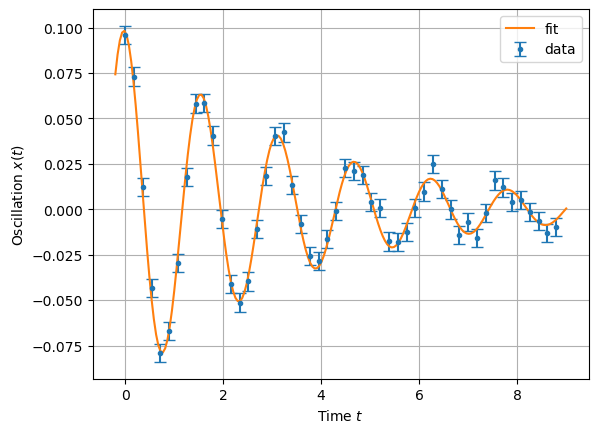

In [38]:
# plotting the data and fitted function for x(t)

t_cont=np.linspace(-0.2,9,200)
plt.errorbar(t_data, x_data, yerr=sigma_x, fmt='.', capsize=4, label='data')
plt.plot(t_cont, x(t_cont, 0.0979, 0.282, 4.027, 0.033), label='fit')
plt.grid()
plt.xlabel(r'Time $t$')
plt.ylabel(r'Oscillation $x(t)$')
plt.legend()

In [47]:
m_A = Minuit(SQ_A, frac=0.35, omega_0=4, beta=0.3)

m_A.migrad()  # run optimiser
m_A.hesse()   # run covariance estimator

print(m_A)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 34.3                       │              Nfcn = 107              │
│ EDM = 7.6e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

In [48]:
# plotting the data and fitted function for x(t)

omega_cont=np.linspace(3,6,200)

plt.plot(omega_cont, A(omega_cont, 0.1999, 4, 0.301), label='fit')
plt.errorbar(omega_data, A_data, yerr=sigma_A, fmt='.', capsize=4, label='data')
plt.grid()
plt.xlabel(r'Eigenfrequency $\omega$')
plt.ylabel(r'Amplitude $A(\omega)$')
plt.legend()